In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
from datetime import datetime
from datetime import timedelta
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    LinearRegressionModel,
    Prophet,
    NBEATSModel
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel


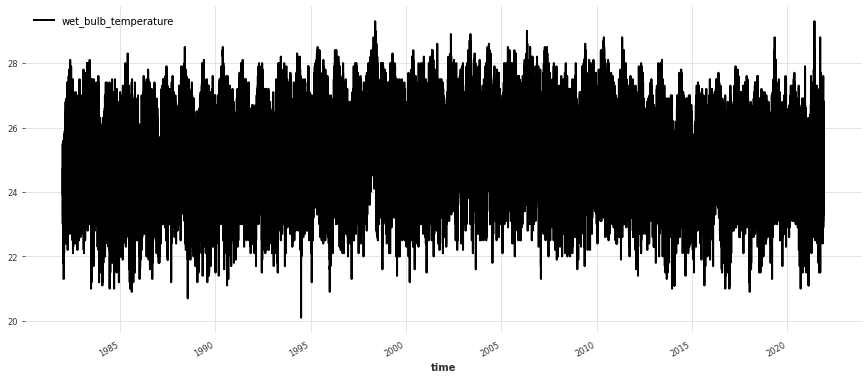

In [5]:
df = pd.read_csv("./data/wet-bulb-temperature-hourly.csv")
dt = [datetime.strptime(df.iloc[n,0], "%Y-%m-%d")+timedelta(hours=int(df.iloc[n,1])-1) for n in range(df.shape[0])]
df.index = dt
df.drop(["wbt_date","wbt_time"],axis=1,inplace=True)
series = TimeSeries.from_dataframe(df)
series.plot()

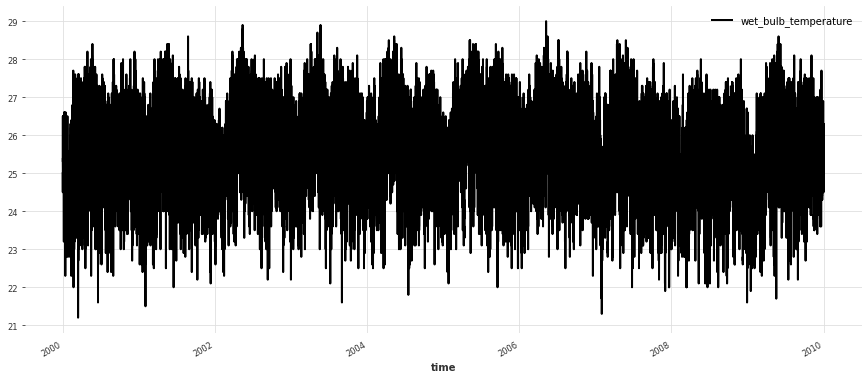

In [6]:
_,series = series.split_before(pd.Timestamp('20000101'))
series,_ = series.split_before(pd.Timestamp('20100101'))
series.plot()

In [7]:
train, val = series.split_before(pd.Timestamp('20060101'))

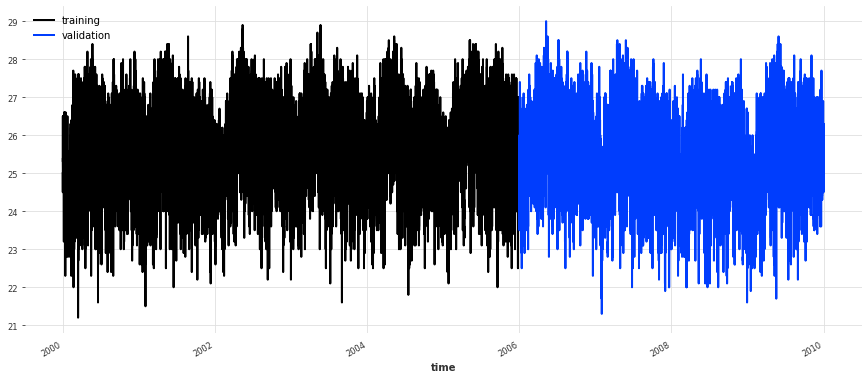

In [8]:
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [11]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(NaiveSeasonal(K=24))
print("\n")
eval_model(LinearRegressionModel(lags=24))
print("\n")
eval_model(Prophet())


model Naive seasonal model, with K=24 obtains MAPE: 3.50%


model LinearRegression(lags=[-24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], lags_past_covariates=None, lags_historical_covariates=None, lags_future_covariates=None obtains MAPE: 3.18%


model Prophet obtains MAPE: 3.43%


In [43]:
model_nbeats = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=24,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=1,
    num_layers=4,
    layer_widths=64,
    n_epochs=20,
    nr_epochs_val_period=1,
    batch_size=16,
    model_name='nbeats_run'
)

In [44]:
model_nbeats.fit(train, val_series=val, verbose=True)


  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
NBEATS_forecast = model_nbeats.predict(len(val))
print('model {} obtains MAPE: {:.2f}%'.format("NBEATS", mape(val,NBEATS_forecast)))

model NBEATS obtains MAPE: 3.88%


In [15]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


In [22]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=16,
    dropout=0,
    batch_size=16,
    n_epochs=30,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Temp_RNN',
    log_tensorboard=True,
    random_state=16,
    training_length=48,
    input_chunk_length=24,
    force_reset=True,
    save_checkpoints=True
)

In [23]:
my_model.fit(train_transformed,
             val_series=val_transformed,
             verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [28]:
forecast = my_model.predict(len(val))
print('model {} obtains MAPE: {:.2f}%'.format("RNN", mape(val_transformed, forecast)))


model RNN obtains MAPE: 39.86%


In [33]:
LR_model = LinearRegressionModel(lags=24)
LR_model.fit(train)
LR_forecast = LR_model.predict(len(val))
print('model {} obtains MAPE: {:.2f}%'.format("LR", mape(val,LR_forecast)))

model LR obtains MAPE: 3.18%


In [31]:
forecast_inv=transformer.inverse_transform(forecast)

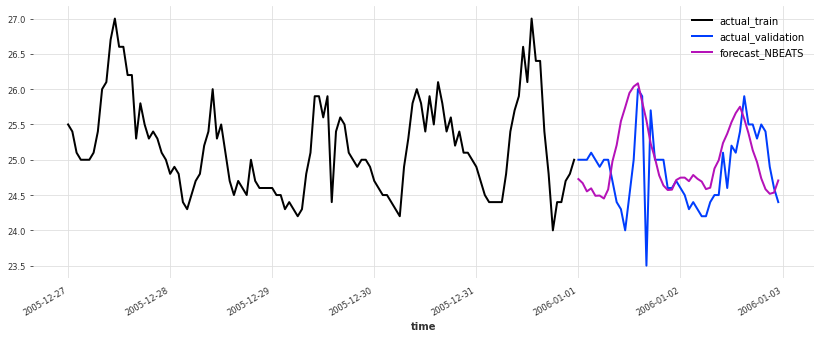

In [48]:
plt.figure(figsize=(14,5))
train[-24*5:].plot(label='actual_train')
val[:24*2].plot(label='actual_validation')
# forecast_inv[:24*2].plot(label='forecast_RNN')
# LR_forecast[:24*2].plot(label='forecast_LR')
NBEATS_forecast[:24*2].plot(label='forecast_NBEATS')
plt.legend();